The AML dataset that will be used in the later stages is extremely small (<100 examples) which usually poses a problem for data-hungry Deep Learning algorithms. 

That's why before we use the custom RoBERT architecture on this task, we will first try it out on a bigger dataset: the  [Kaggle BBC News dataset](https://www.kaggle.com/c/learn-ai-bbc/data). There the task will be similar: to classify long text articles into a category.

This will be a proof-of-concept for our architecture to make sure it works as expected.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import transformers
from sklearn.model_selection import train_test_split

from utilities import utils

RANDOM_STATE = 5

## Data analysis

Let's have a look at the PoC data from the dowloaded csv file:

In [2]:
data_path = Path('../data/')

bbc_data = pd.read_csv(data_path/'BBC_News_Train.csv')
utils.df_summarise(bbc_data)

(1490, 3)

Index(['ArticleId', 'Text', 'Category'], dtype='object')

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Roughly 1.5k examples should be enough for a PoC. Let's review the class distribution:

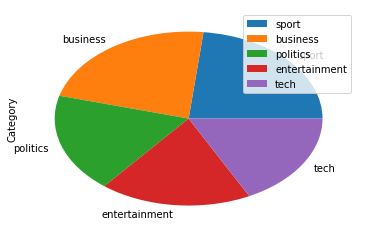

In [3]:
bbc_data.Category.value_counts().plot.pie(legend=True);

Classes are distributed more or less evenly between the categories, so there's no need to intervene in their distribution at this stage.

The backbone of our RoBERT model - the BERT model itself - accepts a sequence of at most 512 tokens. Let's see what is the distribution of the article length - measured in tokens that BERT accepts. To allow this measurement, we'll use the dedicated BERT Tokenizer:

In [4]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
check_num_of_tokens = lambda row: len(tokenizer(row)['input_ids'])

bbc_data['num_of_tokens'] = bbc_data['Text'].apply(check_num_of_tokens)
utils.df_summarise(bbc_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (641 > 512). Running this sequence through the model will result in indexing errors


(1490, 4)

Index(['ArticleId', 'Text', 'Category', 'num_of_tokens'], dtype='object')

,ArticleId,Text,Category,num_of_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,404
1,154,german business confidence slides german busin...,business,418
2,1101,bbc poll indicates economic gloom citizens in ...,business,641
3,1976,lifestyle governs mobile choice faster bett...,tech,735
4,917,enron bosses in $168m payout eighteen former e...,business,453


Notice that the tokenizer warns us the full text token length exceeds the expected model length. Let's look at the historam and token number stats:

count    1490.000000
mean      492.671812
std       258.795913
min       115.000000
25%       329.250000
50%       435.500000
75%       595.000000
max      3818.000000
Name: num_of_tokens, dtype: float64

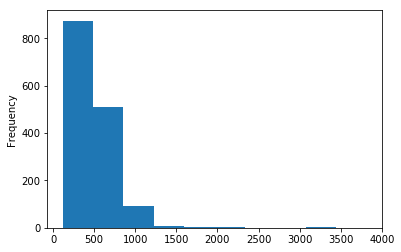

In [5]:
bbc_data['num_of_tokens'].plot.hist()
bbc_data['num_of_tokens'].describe()

As we can see, roughly a third of our data exceeds the minimum requirement. For this very reason, we will be using a custom built RoBERT instead of a pure BERT implementation - it gives us the opportunity to work on any lenght of text.

## Dataset creation

The dataset will be split into the train and validation sets to ensure validation on an out-of-sample set during training. For that we will hold out 20% of the data:

In [6]:
train, val = train_test_split(
    bbc_data, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    shuffle=True, 
    stratify=bbc_data['Category']
    )
for dataset in [train, val]:
    print('='*60)
    print(dataset.shape)
    print(dataset['Category'].value_counts())

(1192, 4)
sport            277
business         269
politics         219
entertainment    218
tech             209
Name: Category, dtype: int64
(298, 4)
sport            69
business         67
entertainment    55
politics         55
tech             52
Name: Category, dtype: int64


In [7]:
train.to_csv(data_path/'bbc_train.csv')
val.to_csv(data_path/'bbc_val.csv')

## Training

For training we will import the model and dataset classes:

In [8]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

from dataset.long_text_data_module import LongTextDataModule
from model.long_text_classifier import LongTextClassifier
from model.callbacks import SwitchPretrainedWeightsState

We will define some of the training hyperparameters. For a detailed set of hyperparameters please also review the config `yaml` file.

Some words on the non-typical hyperparameters used:
* `SEQUENCE_LENGTH` - defines the length (in tokens) of parts the article will be split into to allow processing through the BERT backbone. We will use `200` - the same as the length used by the authors of the arXiv paper.
* `SEQUENCE_OVERLAP` - defines the overlap between sequences, to enable more effective processing of the feature vectors through the overarching LSTM architecture. We will use `50` - again, from the paper.

Due to time & capacity constraints, the current model implementation handles a batch of exactly 1 article - this limitation will likely lead to a more volatile training process. I will address this issue in the future.

In [9]:
NUM_EPOCHS = 20
SEQUENCE_LENGTH = 200
SEQUENCE_OVERLAP = 50
BATCH_SIZE = 1  # TODO: at the moment model can only handle online learning
NUM_FREEZE_PRETRAINED = 0
CONFIG_PATH = 'settings/bbc_config.yaml'


data_module = LongTextDataModule(
    config_path=CONFIG_PATH,
    sequence_length=SEQUENCE_LENGTH,
    overlap=SEQUENCE_OVERLAP
)

model = LongTextClassifier(
    num_classes=data_module.num_classes,
    config_path=CONFIG_PATH,
    num_epochs_freeze_pretrained=NUM_FREEZE_PRETRAINED,
    )

callbacks = [
    SwitchPretrainedWeightsState(),
    ModelCheckpoint(
        filename=f'BBCClassifier-seq_len{SEQUENCE_LENGTH}-ovlp{SEQUENCE_OVERLAP}'+'-{epoch}-{val/accuracy:.3f}',
        monitor='val/accuracy',
        mode='max',
        save_top_k=1,
        verbose=True,
    ),
    EarlyStopping(
        monitor='val/accuracy',
        mode='max',
        patience=5,
        verbose=True,
        ),
]

trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    fast_dev_run=False,
    default_root_dir='../output',
    callbacks=callbacks,
    gpus=1,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Time to train the model:

In [10]:
trainer.fit(
    model,
    data_module.train_dataloader(),
    data_module.val_dataloader(),
)

Tokenisation of content strips:


  0%|          | 0/1192 [00:00<?, ?it/s]

Loaded dataset bbc_train
Number of tokens: 1192
Number of classes: 5
Tokenisation of content strips:


  0%|          | 0/298 [00:00<?, ?it/s]

Loaded dataset bbc_val
Number of tokens: 298
Number of classes: 5


/home/tkaleczy/git/AML_news_detection/environment/aml_venv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name                | Type       | Params
---------------------------------------------------
0 | feature_extractor   | BertModel  | 108 M 
1 | aggregating_network | LSTM       | 348 K 
2 | predictor           | Sequential | 3.2 K 
3 | accuracy            | Accuracy   | 0     
---------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
434.646   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

val/accuracy 0.5


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1191: val/accuracy reached 0.85570 (best 0.85570), saving model to "../output/lightning_logs/version_0/checkpoints/BBCClassifier-seq_len200-ovlp50-epoch=0-val/accuracy=0.856.ckpt" as top 1


val/accuracy 0.8557047247886658


Validating: 0it [00:00, ?it/s]

Epoch 1, step 2383: val/accuracy was not in top 1


val/accuracy 0.8523489832878113


Validating: 0it [00:00, ?it/s]

Epoch 2, step 3575: val/accuracy was not in top 1


val/accuracy 0.8020133972167969


Validating: 0it [00:00, ?it/s]

Epoch 3, step 4767: val/accuracy was not in top 1


val/accuracy 0.818791925907135


Validating: 0it [00:00, ?it/s]

Epoch 4, step 5959: val/accuracy was not in top 1


val/accuracy 0.8322147727012634


Validating: 0it [00:00, ?it/s]

Epoch 5, step 7151: val/accuracy was not in top 1


val/accuracy 0.8255033493041992


1

## Conclusions

As demonstrated above, >85% accuracy can be achieved on a relatively small dataset using the demonstrated architecture - and this result can likely be improved by implementing batch processing and some hyperparameter tuning.

This means this architecture is good to use for our main problem - classifying the AML related articles.